In [1]:
import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data

import math

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(2)
np.random.seed(2)

# правильно выбирайте карту, иначе все упадет!
CUDA_DEVICE = torch.device("cuda") if torch.cuda.is_available else torch.device('cpu')

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    npimg = img.numpy().astype('uint8')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class CustomC100Dataset(data.Dataset):
    def __init__(self, dataset_path, dataset_type, img_cnt = 50000, transform = None, target_transform = None):
        if dataset_type not in ['train', 'test', "val"]:
            raise "Unknown dataset type : {}".format(dataset_type)
        self.ds_type = dataset_type
        self.ds_path = dataset_path
        self.img_cnt = img_cnt
        self.transform = transform
        self.t_transform = target_transform
        self.__load__()
    
    def __load__(self):
        dataset = np.load(self.ds_path)
        if self.ds_type == 'train' or self.ds_type == "val":
            dataset = dataset.reshape((self.img_cnt,3073))
            self.y, self.x = np.hsplit(dataset, [1])
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
        
        if self.ds_type == 'test':
            dataset = dataset.reshape((self.img_cnt,3072))
            self.y = np.zeros((dataset.shape[0], 1), dtype=np.int64)
            self.x = dataset.reshape((dataset.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
    
    def __getitem__(self, index):
        img, target = self.x[index], self.y[index]
        
        img = PIL.Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.t_transform is not None:
            target = self.t_transform(target)
            
        return img, target

    
    def __len__(self):
        return len(self.x)

In [3]:
data_stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train = transforms.Compose([
    # тут надо сделать аугментации и преобразования для trainset
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_stats, inplace=True)
])

transform_test = transforms.Compose([
    # тут так же преобразования, но для testset
    transforms.ToTensor(),
    transforms.Normalize(*data_stats, inplace=True)
])

# подумайте, должны ли преобразования train и test сет быть абсолютно одинаковыми ?

test_nc_dataset = CustomC100Dataset('homework_2_no_classes.test.npy', 'test', img_cnt = 10000, transform = transform_test)

In [4]:
from sklearn.model_selection import train_test_split
train_dataset = np.load("homework_2.train.npy")
buf = train_dataset[:,0]
train, val = train_test_split(train_dataset, test_size = 0.1, stratify=buf, shuffle=True, random_state=30)
np.save("train.npy", train)
np.save("val.npy", val)
train_cnt = train.shape[0]
val_cnt = val.shape[0]
train_dataset = CustomC100Dataset("train.npy", 'train', img_cnt = train_cnt, transform = transform_train)
val_dataset = CustomC100Dataset("val.npy", 'val', img_cnt = val_cnt, transform = transform_test)

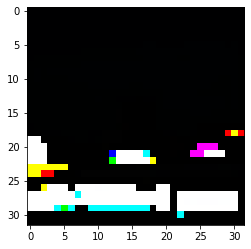

In [5]:
img, label = val_dataset[4]
imshow(img)

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    #"3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        # конструктор базового блока
        super(BasicBlock, self).__init__()
        ## 1. subblock
        self.conv1 = conv3x3(inplanes, planes, stride) # конволюции
        self.bn1 = nn.BatchNorm2d(planes)              # батч нормализация
        self.relu = nn.ReLU(inplace=True)              # нелинейность
        # 2. subblock
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # residual connection if sizes of input features are not equal of output features
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        # форвард базового блока        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
#         super(ResNet, self).__init__()
#         self.inplanes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)# вставить сюда стартовую конволюцию из статьи
#         self.bn1 =  nn.BatchNorm2d(64) # bn-слой
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

#         self.classifier = nn.Sequential(
#             nn.AvgPool2d(4),
#             nn.Flatten(),
#             nn.Linear(64 * block.expansion, num_classes)
#         )
        
#         super(ResNet, self).__init__()
#         self.inplanes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)# вставить сюда стартовую конволюцию из статьи
#         self.bn1 =  nn.BatchNorm2d(64) # bn-слой
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 128, layers[3], stride=2)

#         self.classifier = nn.Sequential(
#             nn.AvgPool2d(4),
#             nn.Flatten(),
#             nn.Linear(128 * block.expansion, num_classes)
#         )

In [7]:
# чтобы вы не запутались, сборку самой модели предоставляем
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)# вставить сюда стартовую конволюцию из статьи
        self.bn1 =  nn.BatchNorm2d(64) # bn-слой
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.classifier = nn.Sequential(
            nn.AvgPool2d(4),
            nn.Flatten(),
            nn.Linear(512 * block.expansion, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                # написать инициализацию параметров конволюции
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                # инициализация параметров батч-нормализаций
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                # здесь необходимо привести слои для downsampling в shotrcut соединениях
                nn.Conv2d(in_channels=self.inplanes, out_channels=planes * block.expansion,
                    kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * block.expansion) # !!!
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return self.classifier(x)

In [8]:
# Выбирайте любой ResNet

# def ResNet20():
#     return ResNet(BasicBlock, [3,3,3], 100)

# def ResNet32():
#     return ResNet(BasicBlock, [5,5,5], 100)

# def ResNet44():
#     return ResNet(BasicBlock, [7,7,7], 100)

# def ResNet56():
#     return ResNet(BasicBlock, [9,9,9], 100)

# def ResNet20():
#     return ResNet(BasicBlock, [3,3,3,3], 100)

# def ResNet32():
#     return ResNet(BasicBlock, [5,5,5,5], 100)

# def ResNet44():
#     return ResNet(BasicBlock, [7,7,7,7], 100)

# def ResNet56():
#     return ResNet(BasicBlock, [9,9,9,9], 100)

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], 100)

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3], 100)

def ResNet50():
    return ResNet(BasicBlock, [3, 4, 6, 3], 100)

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3], 100)

In [9]:
def acc_check(model, validation_loader, batch_size):
    model.eval()
    correct = 0.0
    total = 0.0
    with torch.no_grad():
      for batch_idx, (inputs, labels) in enumerate(validation_loader):
          inputs, labels = inputs.cuda(), labels.view(batch_size).cuda()
          outputs = model(inputs)
          outputs = F.softmax(outputs)
          prob, predicted = torch.topk(outputs.data, 1)
          total += labels.size(0)
          correct += predicted.view(-1).eq(labels.data).sum()
        
    model.train()
    return (correct / total)

In [10]:
def make_solution_pytorch(model, test_data_loader, batch_size):
    res = []
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.cuda(), labels.view(batch_size).cuda()
        outputs = model(inputs)
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        res = np.append(res, predicted.view(-1).cpu().numpy())
    model.train()
    return res

In [11]:
CUDA_DEVICE

device(type='cuda')

In [12]:
#Обучение ResNet
#Не забудьте вывести графики accuracy (можно использовать acc_check()) и loss при обучении

model = ResNet34() # ResNet34
model.cuda(CUDA_DEVICE)

#all parameters from https://arxiv.org/pdf/1512.03385.pdf
epochs_cnt = 40

# эти параметры тоже на ваше усмотрение
minibatch_size = 60 # 125 
val_batch_size = 100
test_batch_size = 100

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True) # выбираем отимизатор 
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00005, max_lr=0.1, step_size_up=5,mode="triangular2")
criterion = nn.CrossEntropyLoss().cuda(CUDA_DEVICE)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = minibatch_size, shuffle = True, num_workers = 2, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = val_batch_size, shuffle = True, num_workers = 2, drop_last = True)
test_nc_loader = torch.utils.data.DataLoader(test_nc_dataset, batch_size = test_batch_size, shuffle = False, num_workers = 2)
losses_train = []
losses_val = []
train_pred = []
val_pred = []

# примерный код для обучения модели, не обязательно строго следовать ему
for epoch in tqdm(range(epochs_cnt)):    
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    # обучаемся
    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(CUDA_DEVICE), labels.view(minibatch_size).to(CUDA_DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.data
        train_acc += (outputs.argmax(axis = 1) == labels).sum()
        loss.backward()
        optimizer.step()
    cur_lr = scheduler.get_last_lr()
    scheduler.step()
    # считаем метрику и лосс на трейне
    train_acc = train_acc / (batch_idx + 1) / minibatch_size
    train_pred.append(train_acc.cpu().numpy())
    train_loss = train_loss / (batch_idx + 1) 
    losses_train.append(train_loss.cpu().numpy())
    # переводим модель в предсказательный режим
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        inputs, labels = inputs.to(CUDA_DEVICE), labels.view(val_batch_size).to(CUDA_DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.data
        val_acc += (outputs.argmax(axis = 1) == labels).sum()
    # считаем метрику и лосс на отложенном 
    val_acc = val_acc / (batch_idx + 1) / val_batch_size
    val_pred.append(val_acc.cpu().numpy())
    val_loss = val_loss / (batch_idx + 1)
    losses_val.append(val_loss.cpu().numpy())
    # фиксируем прибыль
    print(f"\nepoch: {epoch + 1}\nlr: {str(cur_lr[0])[:7]}")
    print(f"Train accuracy: {train_acc}\nTrain loss: {train_loss}")
    print(f"Validation accuracy: {val_acc}\nValidation loss: {val_loss}")


print('Finished Training')

  2%|▎         | 1/40 [00:43<28:01, 43.12s/it]


epoch: 1
lr: 0.001
Train accuracy: 0.07937778532505035
Train loss: 4.115959167480469
Validation accuracy: 0.14179998636245728
Validation loss: 3.69987154006958


  5%|▌         | 2/40 [01:26<27:21, 43.19s/it]


epoch: 2
lr: 0.02080
Train accuracy: 0.14964444935321808
Train loss: 3.6297199726104736
Validation accuracy: 0.22379998862743378
Validation loss: 3.167527675628662


  8%|▊         | 3/40 [02:09<26:39, 43.22s/it]


epoch: 3
lr: 0.0406
Train accuracy: 0.25913333892822266
Train loss: 2.9226181507110596
Validation accuracy: 0.30719998478889465
Validation loss: 2.8197646141052246


 10%|█         | 4/40 [02:53<26:00, 43.34s/it]


epoch: 4
lr: 0.06040
Train accuracy: 0.3568666875362396
Train loss: 2.436779737472534
Validation accuracy: 0.3643999695777893
Validation loss: 2.4383490085601807


 12%|█▎        | 5/40 [03:37<25:20, 43.44s/it]


epoch: 5
lr: 0.0802
Train accuracy: 0.4342889189720154
Train loss: 2.09651780128479
Validation accuracy: 0.4487999677658081
Validation loss: 2.0515739917755127


 15%|█▌        | 6/40 [04:20<24:38, 43.49s/it]


epoch: 6
lr: 0.1
Train accuracy: 0.48428890109062195
Train loss: 1.8762128353118896
Validation accuracy: 0.48899996280670166
Validation loss: 1.8735567331314087


 18%|█▊        | 7/40 [05:04<23:57, 43.55s/it]


epoch: 7
lr: 0.0802
Train accuracy: 0.5432222485542297
Train loss: 1.6247581243515015
Validation accuracy: 0.5135999917984009
Validation loss: 1.7858312129974365


 20%|██        | 8/40 [05:47<23:13, 43.56s/it]


epoch: 8
lr: 0.06040
Train accuracy: 0.6007333397865295
Train loss: 1.400664210319519
Validation accuracy: 0.5745999813079834
Validation loss: 1.5279477834701538


 22%|██▎       | 9/40 [06:31<22:29, 43.53s/it]


epoch: 9
lr: 0.0406
Train accuracy: 0.6467334032058716
Train loss: 1.2131166458129883
Validation accuracy: 0.5871999859809875
Validation loss: 1.477333664894104


 25%|██▌       | 10/40 [07:15<21:48, 43.62s/it]


epoch: 10
lr: 0.02080
Train accuracy: 0.7010000348091125
Train loss: 1.0036945343017578
Validation accuracy: 0.6295999884605408
Validation loss: 1.29306161403656


 28%|██▊       | 11/40 [07:58<21:02, 43.53s/it]


epoch: 11
lr: 0.001
Train accuracy: 0.755311131477356
Train loss: 0.8133752346038818
Validation accuracy: 0.6567999720573425
Validation loss: 1.2063957452774048


 30%|███       | 12/40 [08:41<20:17, 43.47s/it]


epoch: 12
lr: 0.01090
Train accuracy: 0.7474222779273987
Train loss: 0.8358754515647888
Validation accuracy: 0.6469999551773071
Validation loss: 1.2562798261642456


 32%|███▎      | 13/40 [09:25<19:31, 43.39s/it]


epoch: 13
lr: 0.02080
Train accuracy: 0.7291333675384521
Train loss: 0.8867141008377075
Validation accuracy: 0.6339999437332153
Validation loss: 1.3260432481765747


 35%|███▌      | 14/40 [10:08<18:47, 43.36s/it]


epoch: 14
lr: 0.03069
Train accuracy: 0.7231555581092834
Train loss: 0.9142385721206665
Validation accuracy: 0.6255999803543091
Validation loss: 1.3315290212631226


 38%|███▊      | 15/40 [10:51<18:02, 43.32s/it]


epoch: 15
lr: 0.0406
Train accuracy: 0.7178000211715698
Train loss: 0.9273576736450195
Validation accuracy: 0.6164000034332275
Validation loss: 1.4034762382507324


 40%|████      | 16/40 [11:34<17:18, 43.28s/it]


epoch: 16
lr: 0.0505
Train accuracy: 0.7174667119979858
Train loss: 0.9263078570365906
Validation accuracy: 0.6073999404907227
Validation loss: 1.4669393301010132


 42%|████▎     | 17/40 [12:18<16:35, 43.26s/it]


epoch: 17
lr: 0.0406
Train accuracy: 0.7544222474098206
Train loss: 0.8022632598876953
Validation accuracy: 0.6279999613761902
Validation loss: 1.4707657098770142


 45%|████▌     | 18/40 [13:01<15:51, 43.24s/it]


epoch: 18
lr: 0.03069
Train accuracy: 0.7889778017997742
Train loss: 0.6738707423210144
Validation accuracy: 0.6571999788284302
Validation loss: 1.303024411201477


 48%|████▊     | 19/40 [13:44<15:08, 43.24s/it]


epoch: 19
lr: 0.02080
Train accuracy: 0.8300000429153442
Train loss: 0.5378511548042297
Validation accuracy: 0.6613999605178833
Validation loss: 1.3083692789077759


 50%|█████     | 20/40 [14:27<14:25, 43.26s/it]


epoch: 20
lr: 0.01090
Train accuracy: 0.8730889558792114
Train loss: 0.3978346288204193
Validation accuracy: 0.6850000023841858
Validation loss: 1.3039860725402832


 52%|█████▎    | 21/40 [15:10<13:41, 43.26s/it]


epoch: 21
lr: 0.001
Train accuracy: 0.910111129283905
Train loss: 0.2906513512134552
Validation accuracy: 0.6959999799728394
Validation loss: 1.2124793529510498


 55%|█████▌    | 22/40 [15:54<12:58, 43.26s/it]


epoch: 22
lr: 0.00595
Train accuracy: 0.9074222445487976
Train loss: 0.29096516966819763
Validation accuracy: 0.6922000050544739
Validation loss: 1.2757246494293213


 57%|█████▊    | 23/40 [16:37<12:15, 43.27s/it]


epoch: 23
lr: 0.01090
Train accuracy: 0.8980222344398499
Train loss: 0.3166968524456024
Validation accuracy: 0.6815999746322632
Validation loss: 1.3075650930404663


 60%|██████    | 24/40 [17:20<11:32, 43.30s/it]


epoch: 24
lr: 0.01584
Train accuracy: 0.8864444494247437
Train loss: 0.34587642550468445
Validation accuracy: 0.6782000064849854
Validation loss: 1.3662384748458862


 62%|██████▎   | 25/40 [18:04<10:49, 43.28s/it]


epoch: 25
lr: 0.0208
Train accuracy: 0.8737999796867371
Train loss: 0.38457900285720825
Validation accuracy: 0.6708000302314758
Validation loss: 1.3881250619888306


 65%|██████▌   | 26/40 [18:47<10:05, 43.26s/it]


epoch: 26
lr: 0.02575
Train accuracy: 0.8610444664955139
Train loss: 0.4171821177005768
Validation accuracy: 0.6479999423027039
Validation loss: 1.4729396104812622


 68%|██████▊   | 27/40 [19:30<09:22, 43.24s/it]


epoch: 27
lr: 0.0208
Train accuracy: 0.8860666751861572
Train loss: 0.34428560733795166
Validation accuracy: 0.6741999387741089
Validation loss: 1.3954194784164429


 70%|███████   | 28/40 [20:14<08:39, 43.32s/it]


epoch: 28
lr: 0.01584
Train accuracy: 0.9151555895805359
Train loss: 0.2609919607639313
Validation accuracy: 0.6787999868392944
Validation loss: 1.4271583557128906


 72%|███████▎  | 29/40 [20:57<07:56, 43.29s/it]


epoch: 29
lr: 0.01090
Train accuracy: 0.9391555786132812
Train loss: 0.18582738935947418
Validation accuracy: 0.6893999576568604
Validation loss: 1.4169068336486816


 75%|███████▌  | 30/40 [21:40<07:12, 43.24s/it]


epoch: 30
lr: 0.00595
Train accuracy: 0.9604222774505615
Train loss: 0.1308964341878891
Validation accuracy: 0.7005999684333801
Validation loss: 1.408842921257019


 78%|███████▊  | 31/40 [22:23<06:28, 43.22s/it]


epoch: 31
lr: 0.001
Train accuracy: 0.9727556109428406
Train loss: 0.09568396210670471
Validation accuracy: 0.7075999975204468
Validation loss: 1.3891266584396362


 80%|████████  | 32/40 [23:06<05:45, 43.23s/it]


epoch: 32
lr: 0.00347
Train accuracy: 0.9736000299453735
Train loss: 0.09146513789892197
Validation accuracy: 0.7059999704360962
Validation loss: 1.411536693572998


 82%|████████▎ | 33/40 [23:49<05:02, 43.18s/it]


epoch: 33
lr: 0.00595
Train accuracy: 0.9696222543716431
Train loss: 0.1004718691110611
Validation accuracy: 0.6983999609947205
Validation loss: 1.4449665546417236


 85%|████████▌ | 34/40 [24:33<04:18, 43.16s/it]


epoch: 34
lr: 0.00842
Train accuracy: 0.9680666923522949
Train loss: 0.10367262363433838
Validation accuracy: 0.7001999616622925
Validation loss: 1.4731943607330322


 88%|████████▊ | 35/40 [25:16<03:35, 43.16s/it]


epoch: 35
lr: 0.01090
Train accuracy: 0.9629555940628052
Train loss: 0.11766020953655243
Validation accuracy: 0.693399965763092
Validation loss: 1.5068585872650146


 90%|█████████ | 36/40 [25:59<02:52, 43.18s/it]


epoch: 36
lr: 0.01337
Train accuracy: 0.9534223079681396
Train loss: 0.14301227033138275
Validation accuracy: 0.6782000064849854
Validation loss: 1.614726185798645


 92%|█████████▎| 37/40 [26:42<02:09, 43.18s/it]


epoch: 37
lr: 0.01090
Train accuracy: 0.9620222449302673
Train loss: 0.11954323947429657
Validation accuracy: 0.686199963092804
Validation loss: 1.5805641412734985


 95%|█████████▌| 38/40 [27:25<01:26, 43.17s/it]


epoch: 38
lr: 0.00842
Train accuracy: 0.971844494342804
Train loss: 0.09290820360183716
Validation accuracy: 0.6941999793052673
Validation loss: 1.5186748504638672


 98%|█████████▊| 39/40 [28:08<00:43, 43.18s/it]


epoch: 39
lr: 0.00595
Train accuracy: 0.9805334210395813
Train loss: 0.06696868687868118
Validation accuracy: 0.7049999833106995
Validation loss: 1.5067663192749023


100%|██████████| 40/40 [28:52<00:00, 43.30s/it]


epoch: 40
lr: 0.00347
Train accuracy: 0.9863333702087402
Train loss: 0.04970376938581467
Validation accuracy: 0.7037999629974365
Validation loss: 1.5111972093582153
Finished Training


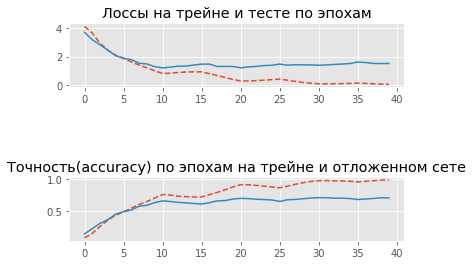

In [13]:
import pylab

plt.style.use('ggplot')
# Две строки, два столбца. Текущая ячейка - 1
plt.subplot (3, 1, 1)
plt.plot(list(range(int(epochs_cnt))), losses_train, "--")
plt.plot(list(range(int(epochs_cnt))), losses_val, label='val loss')
plt.title ("Лоссы на трейне и тесте по эпохам")

# Две строки, два столбца. Текущая ячейка - 3
plt.subplot (3, 1, 3)
plt.plot(list(range(int(epochs_cnt))), train_pred, "--" )
plt.plot(list(range(int(epochs_cnt))), val_pred, label="val acc" )     
plt.title ("Точность(accuracy) по эпохам на трейне и отложенном сете")

# Покажем окно с нарисованным графиком
plt.show()

In [14]:
# генерим решение вашей модели
solution = make_solution_pytorch(model, test_nc_loader, test_batch_size)
with open("my_solutionResNet34_"+str(epochs_cnt)+"epoch_"+str(train_pred[-1])[2:4]+"_"+str(val_pred[-1])[2:4]+".csv", 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(solution):
        print(i, int(prediction), sep=',', file=fout)

/home/iv.borisov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [15]:
acc_check(model, train_loader, minibatch_size)

/home/iv.borisov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


tensor(0.9941, device='cuda:0')

In [16]:
acc_check(model, val_loader, val_batch_size)

/home/iv.borisov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


tensor(0.7038, device='cuda:0')